## Lexical Diversity Exploration

This notebook explores the degree of word repetition, which is the inverse of "lexical diversity." Lexical diversity is the ratio of unique words (i.e. vocabulary) to total words in a given body of work.

It starts with the standard library loads.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


Load additional:

In [2]:
import itertools
import collections
import json
import pickle
import nltk

#this only necessary first time through, hence commented out
#nltk.download()

In [3]:
# Open everything that's been saved in /data/conditioned
df=pd.read_csv("../../data/conditioned/use-this-master-lyricsdf-extracted.csv")
dfg=pd.read_csv("../../data/conditioned/master-lyricsdf-genre_inner.csv")

with open("../../data/conditioned/noun-n-gram.json") as json_file:
    noungram = json.load(json_file)
with open("../../data/conditioned/nounvocab.json") as json_file:
    nounvocab = json.load(json_file)
with open("../../data/conditioned/nounid2word.json") as json_file:
    nounid2word = json.load(json_file)
with open("../../data/conditioned/adj-n-gram.json") as json_file:
    adjgram = json.load(json_file)
with open("../../data/conditioned/adjvocab.json") as json_file:
    adjvocab = json.load(json_file)
with open("../../data/conditioned/adjid2word.json") as json_file:
    adjvocab = json.load(json_file)
with open("../../data/conditioned/decade-dict.json") as json_file:
    decade_dict = json.load(json_file)
    

f = open("../../data/conditioned/ahypes.p",'r')  
ahypes = pickle.load(f)  
f = open("../../data/conditioned/nhypes.p",'r')  
nhypes = pickle.load(f)
f = open("../../data/conditioned/corpus.p",'r')  
corpus = pickle.load(f)

# open the genre dictionary
with open("../../notebooks/ss/songsbygenre.json") as json_file:
    genre_dict = json.load(json_file)


df.head(3)

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract
0,0,1,1970,https://en.wikipedia.org/wiki/Bridge_over_Trou...,Bridge over Troubled Water,Simon and Garfunkel,When you're weary. Feeling small. When tears a...,1970,1970-1,http://lyrics.wikia.com/Simon_And_Garfunkel:Br...,When you're weary. Feeling small. When tears a...
1,1,2,1970,https://en.wikipedia.org/wiki/(They_Long_to_Be...,(They Long to Be) Close to You,The Carpenters,Why do birds suddenly appear. Everytime you ar...,1970,1970-2,http://lyrics.wikia.com/Carpenters:%28They_Lon...,Why do birds suddenly appear. Everytime you ar...
2,2,3,1970,https://en.wikipedia.org/wiki/American_Woman_(...,American Woman,The Guess Who,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d...",1970,1970-3,http://lyrics.wikia.com/The_Guess_Who:American...,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d..."


## Low Hanging Fruit- Descriptive Statistics
### Across the Database and Partitioned By Genre and Decade
- word counts
- song length
- lexical diversity/ repetition count

Stored in JSON objects suitable for visualizations

# measure the df and the deades and the genres 
decades=df.decade.unique()
df.shape, len(decades), len(genre_dict)

## Repetition of Words Within Songs

Repetition of words or phrases is a frequently used design element in music lyrics. Comparison of text analysis of lyrics to text analysis of prose could therefore be uninformative or even misleading. While this subject alone could merit extensive study, at the point we make some effort to quantify the degree of repetition contained in each song by calculating its lexical diversity using NLTK, as described in Bird,Klein, and Loper [Natural Language Processing with Python](http://www.nltk.org/book/). A column for lexical diversity is added to each row of the dataframe.  

In [4]:
## should not be needed since bad data has been removed from the df.................

# eliminate " We don't currently have a license"
counter=0
#eliminate rows with null lyrics
dfc = df[pd.isnull(df.lyrics)==False]


for row in dfc.iterrows():
    if row[1][6].startswith("We don't currently have a license"):
        dfc.iloc[row[1][1],6]="Instrumental"
    counter+=1
    if counter >3000:
        break


#eliminate instrumentals
dfc = dfc[df.lyrics!="Instrumental"]
# eliminate " 	We don't currently have a license"

dfc.shape
dfc.head()

C:\Users\sss\Anaconda\lib\site-packages\pandas\core\frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract
0,0,1,1970,https://en.wikipedia.org/wiki/Bridge_over_Trou...,Bridge over Troubled Water,Simon and Garfunkel,When you're weary. Feeling small. When tears a...,1970,1970-1,http://lyrics.wikia.com/Simon_And_Garfunkel:Br...,When you're weary. Feeling small. When tears a...
1,1,2,1970,https://en.wikipedia.org/wiki/(They_Long_to_Be...,(They Long to Be) Close to You,The Carpenters,Why do birds suddenly appear. Everytime you ar...,1970,1970-2,http://lyrics.wikia.com/Carpenters:%28They_Lon...,Why do birds suddenly appear. Everytime you ar...
2,2,3,1970,https://en.wikipedia.org/wiki/American_Woman_(...,American Woman,The Guess Who,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d...",1970,1970-3,http://lyrics.wikia.com/The_Guess_Who:American...,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d..."
3,3,4,1970,https://en.wikipedia.org/wiki/Raindrops_Keep_F...,Raindrops Keep Fallin' on My Head,B.J. Thomas,Raindrops are falling on my head. And just lik...,1970,1970-4,http://lyrics.wikia.com/B.J._Thomas:Raindrops_...,Raindrops are falling on my head. And just lik...
4,4,5,1970,https://en.wikipedia.org/wiki/War_(Edwin_Starr...,War,Edwin Starr,"War, huh, yeah. What is it good for? Absolutel...",1970,1970-5,http://lyrics.wikia.com/Edwin_Starr:War,"War, huh, yeah. What is it good for? Absolutel..."


In [5]:
# make an array containing lexical diversity of each song
wordset=[]
wordcount=[]
lexdivs=[]
repscore=[]
counter=0
for row in dfc.iterrows():
    k=row[1][6]
    d=len(nltk.word_tokenize(k))
    n=len(set(nltk.word_tokenize(k)))
    wordset.append(1.0*n)
    wordcount.append(1.0*d)    

In [6]:
dfc['wordcount']=wordcount
dfc['wordset']=wordset
lexdivs= np.array(wordset)/np.array(wordcount)
dfc['lexdiv']=lexdivs
dfc['repetition_score']= 1/lexdivs
print len(lexdivs), len(dfc)
dfc.head(2)

4341 4341


,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract,wordcount,wordset,lexdiv,repetition_score
0,0,1,1970,https://en.wikipedia.org/wiki/Bridge_over_Trou...,Bridge over Troubled Water,Simon and Garfunkel,When you're weary. Feeling small. When tears a...,1970,1970-1,http://lyrics.wikia.com/Simon_And_Garfunkel:Br...,When you're weary. Feeling small. When tears a...,201,82,0.407960,2.451220
1,1,2,1970,https://en.wikipedia.org/wiki/(They_Long_to_Be...,(They Long to Be) Close to You,The Carpenters,Why do birds suddenly appear. Everytime you ar...,1970,1970-2,http://lyrics.wikia.com/Carpenters:%28They_Lon...,Why do birds suddenly appear. Everytime you ar...,252,65,0.257937,3.876923


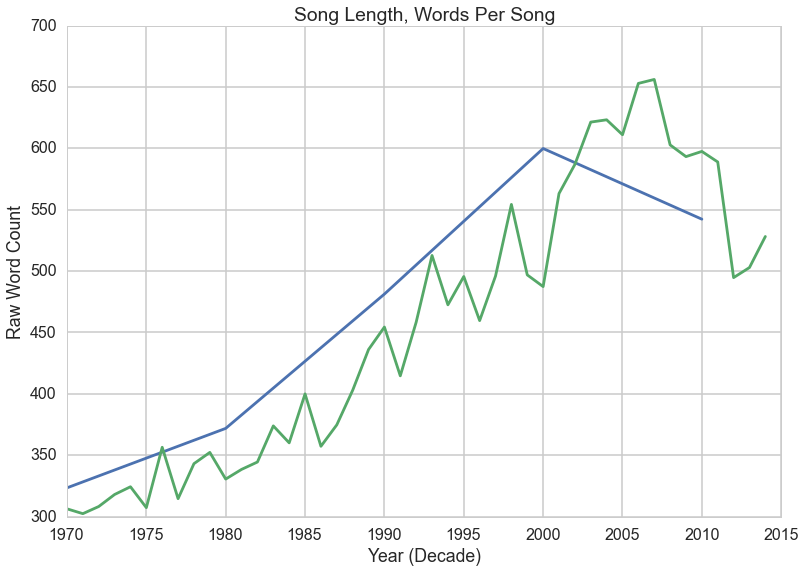

In [18]:
def lexplot(stat,title,ylab):
    years=dfc.groupby('decade')
    yearlexdiv= dict()
    for year in years:
        yearlexdiv[year[0]]= year[1][stat].mean()
    plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
    #plt.ylim([0,1])
    plt.title(title)
    plt.ylabel(ylab)
    plt.xlabel("Year (Decade)")
    x=plotdict.keys()
    y=plotdict.values()
    plt.plot(x,y)

    years=dfc.groupby('year')
    yearlexdiv= dict()
    for year in years:
        yearlexdiv[year[0]]= year[1][stat].mean()
    plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
    x=plotdict.keys()
    y=plotdict.values()
    plt.plot(x,y)
lexplot('wordcount',"Song Length, Words Per Song","Raw Word Count")

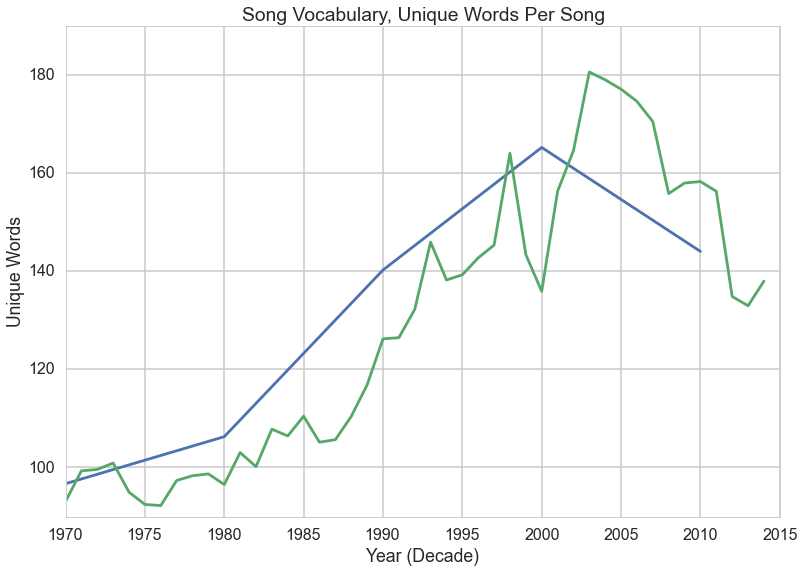

In [20]:
lexplot("wordset","Song Vocabulary, Unique Words Per Song","Unique Words")

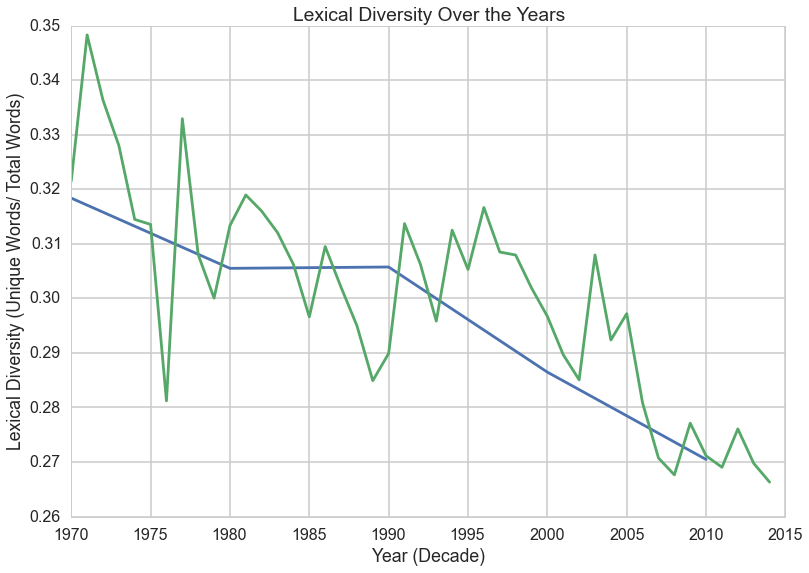

In [21]:
lexplot('lexdiv',"Lexical Diversity Over the Years","Lexical Diversity (Unique Words/ Total Words)")

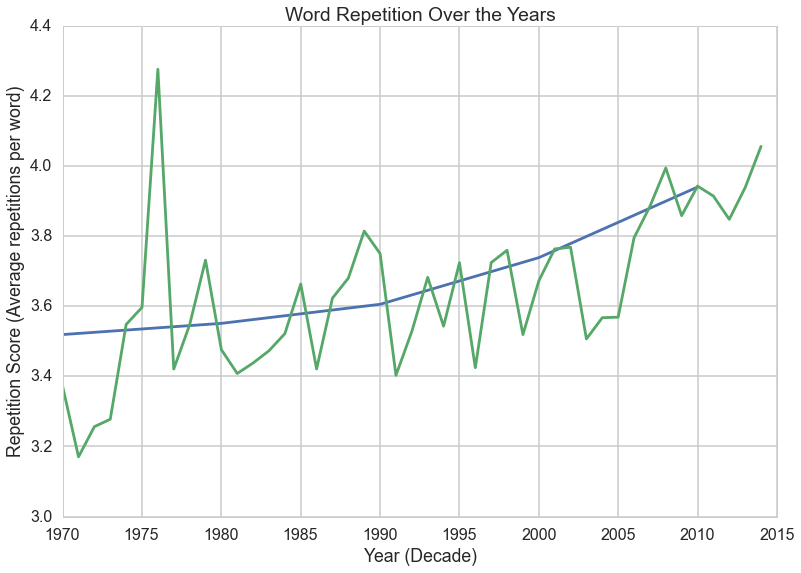

In [22]:
lexplot('repetition_score',"Word Repetition Over the Years","Repetition Score (Average repetitions per word)")

In [11]:
dfc.sort(columns='repetition_score', inplace=True,ascending=False)
dfc.head(10)

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract,wordcount,wordset,lexdiv,repetition_score
2834,2834,35,1998,https://en.wikipedia.org/wiki/Tubthumping,Tubthumping,Chumbawamba,We'll be singing. When we're winning. We'll be...,1990,1998-35,http://lyrics.wikia.com/Chumbawamba:Tubthumping,We'll be singing. When we're winning. We'll be...,1443,56,0.038808,25.767857
2769,2769,70,1997,https://en.wikipedia.org/wiki/Tubthumping,Tubthumping,Chumbawamba,We'll be singing. When we're winning. We'll be...,1990,1997-70,http://lyrics.wikia.com/Chumbawamba:Tubthumping,We'll be singing. When we're winning. We'll be...,1443,56,0.038808,25.767857
692,692,93,1976,https://en.wikipedia.org/wiki/Give_Up_the_Funk...,Give Up the Funk (Tear the Roof off the Sucker),Parliament,". You've got a real type of thing going down, ...",1970,1976-93,http://lyrics.wikia.com/Parliament:Give_Up_The...,". You've got a real type of thing going down, ...",949,58,0.061117,16.362069
2575,2575,76,1995,https://en.wikipedia.org/wiki/Short_Dick_Man,Short Dick Man,20 Fingers,"Ah, ah. Ah, ah. Ah, ah, ah, ah. Ah, ah. Ah, ah...",1990,1995-76,http://lyrics.wikia.com/20_Fingers:Short_Dick_Man,"Ah, ah. Ah, ah. Ah, ah, ah, ah. Ah, ah. Ah, ah...",1026,71,0.069201,14.450704
623,623,24,1976,https://en.wikipedia.org/wiki/Get_Up_and_Boogi...,Get Up and Boogie,Silver Convention,"(That's right). Get up and boogie, get up and ...",1970,1976-24,http://lyrics.wikia.com/Silver_Convention:Get_...,"(That's right). Get up and boogie, get up and ...",176,13,0.073864,13.538462
613,613,14,1976,"https://en.wikipedia.org/wiki/Fly,_Robin,_Fly","Fly, Robin, Fly",Silver Convention,"Fly, robin, fly. Fly, robin, fly. Fly, robin, ...",1970,1976-14,http://lyrics.wikia.com/Silver_Convention:Fly%...,"Fly, robin, fly. Fly, robin, fly. Fly, robin, ...",132,10,0.075758,13.200000
520,520,21,1975,https://en.wikipedia.org/wiki/The_Hustle_(song),The Hustle,Van McCoy,. Do it. Do it. Do it. Do the Hustle. Do the H...,1970,1975-21,http://lyrics.wikia.com/Van_McCoy:The_Hustle,. Do it. Do it. Do it. Do the Hustle. Do the H...,60,5,0.083333,12.000000
411,411,12,1974,https://en.wikipedia.org/wiki/Jungle_Boogie,Jungle Boogie,Kool and the Gang,"Get down, get down. Get down, get down. Get do...",1970,1974-12,http://lyrics.wikia.com/Kool_%26_The_Gang:Jung...,"Get down, get down. Get down, get down. Get do...",467,44,0.094218,10.613636
644,644,45,1976,https://en.wikipedia.org/wiki/That%27s_the_Way...,That's the Way (I Like It),KC and the Sunshine Band,Do do do do do do do do do. Do do do do do do ...,1970,1976-45,http://lyrics.wikia.com/KC_And_The_Sunshine_Ba...,Do do do do do do do do do. Do do do do do do ...,506,49,0.096838,10.326531
629,629,30,1976,https://en.wikipedia.org/wiki/Love_Rollercoaster,Love Rollercoaster,Ohio Players,"Rollercoaster, of love (Say what?). Rollercoas...",1970,1976-30,http://lyrics.wikia.com/Ohio_Players:Love_Roll...,"Rollercoaster, of love (Say what?). Rollercoas...",782,77,0.098465,10.155844


In [12]:
dfc.sort(columns='repetition_score', inplace=True,ascending=True)
dfc.head(10)

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract,wordcount,wordset,lexdiv,repetition_score
478,478,79,1974,NaN,Tubular Bells,Mike Oldfield,{{disambig|Tubular Bells}}\n#the albums\n#*[[M...,1970,1974-79,http://lyrics.wikia.com/Mike_Oldfield:Tubular_...,{{disambig|Tubular Bells}}\n#the albums\n#*[[M...,22,17,0.772727,1.294118
685,685,86,1976,https://en.wikipedia.org/wiki/Who%27d_She_Coo%3F,Who'd She Coo?,Ohio Players,Are you ready\nDo what you wanna do\nDo what y...,1970,1976-86,http://lyrics.wikia.com/Ohio_Players:Who%27d_S...,Are you ready\nDo what you wanna do\nDo what y...,35,26,0.742857,1.346154
1458,1458,59,1984,https://en.wikipedia.org/wiki/Almost_Paradise,Almost Paradise,Mike Reno,I thought that dreams belonged to other men 'C...,1980,1984-59,http://lyrics.wikia.com/index.php?title=Mike_R...,I thought that dreams belonged to other men 'C...,144,104,0.722222,1.384615
1060,1060,61,1980,https://en.wikipedia.org/wiki/Daydream_Believer,Daydream Believer,Anne Murray,Oh I could hide 'neath the wings of the blue b...,1980,1980-61,http://lyrics.wikia.com/Anne_Murray:Daydream_B...,Oh I could hide 'neath the wings of the blue b...,114,79,0.692982,1.443038
179,179,80,1971,https://en.wikipedia.org/wiki/Amazing_Grace,Amazing Grace,Judy Collins,Amazing grace! How sweet the sound. That saved...,1970,1971-80,http://lyrics.wikia.com/Judy_Collins:Amazing_G...,Amazing grace! How sweet the sound. That saved...,128,86,0.671875,1.488372
703,703,4,1977,https://en.wikipedia.org/wiki/Evergreen_(Love_...,Evergreen (Love Theme from A Star Is Born),Barbra Streisand,"Love, soft as an easy chair. Love, fresh as th...",1970,1977-4,http://lyrics.wikia.com/Barbra_Streisand:Everg...,"Love, soft as an easy chair. Love, fresh as th...",128,82,0.640625,1.560976
1386,1386,87,1983,https://en.wikipedia.org/wiki/Lawyers_in_Love_...,Lawyers in Love,Jackson Browne,I can't keep up with what's been going down. I...,1980,1983-87,http://lyrics.wikia.com/Jackson_Browne:Lawyers...,I can't keep up with what's been going down. I...,168,107,0.636905,1.570093
820,820,21,1978,https://en.wikipedia.org/wiki/Feels_So_Good_(c...,Feels So Good,Chuck Mangione,There's no place for me to hide. The thoughts ...,1970,1978-21,http://lyrics.wikia.com/Chuck_Mangione:Feels_S...,There's no place for me to hide. The thoughts ...,118,74,0.627119,1.594595
135,135,36,1971,https://en.wikipedia.org/wiki/Help_Me_Make_It_...,Help Me Make It Through the Night,Sammi Smith,Take the ribbon from my hair. Shake it loose a...,1970,1971-36,http://lyrics.wikia.com/Sammi_Smith:Help_Me_Ma...,Take the ribbon from my hair. Shake it loose a...,128,79,0.617188,1.620253
1799,1799,100,1987,https://en.wikipedia.org/wiki/Love_You_Down,Love You Down,Ready for the World,It never really matter too much to me. That yo...,1980,1987-100,http://lyrics.wikia.com/Ready_For_The_World:Lo...,It never really matter too much to me. That yo...,81,49,0.604938,1.653061
